### Convolutional neural network that approximates the map
### $$F: \{ \zeta_{i},P^{\mathcal{M}}(\zeta_{i})\}_{i=1}^{N} \mapsto \theta$$
For SABR we have
### $$F: \{ K_{i},T_{j},P^{\mathcal{M}(\alpha,\beta,\rho)}(K_{i},T_{j})\}_{i=1,j=1}^{N,M} \mapsto (\alpha,\beta,\rho)$$
### $$F: \Re^{N} \times \Re^{M} \times \Re^{3} \rightarrow \Re^{3} $$


In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from math import sqrt
from scipy.stats import norm
from scipy.stats import uniform
from sklearn.preprocessing import MinMaxScaler
import scipy
from IPython.display import clear_output
import multiprocessing

In [153]:
num_model_parameters = 3
num_strikes = 16
num_maturities = 16


num_input_parameters = num_strikes * num_maturities * 3
num_output_parameters = num_model_parameters
learning_rate = 0.00001
num_steps = 30
batch_size = 10
#num_neurons = 30

#initial values
S0 = 1.0
V0 = 0.1
r = 0.05


contract_bounds = np.array([[0.6*S0,1.2*S0],[1,10]]) #bounds for K,T
model_bounds = np.array([[0.01,0.15],[0,1],[-1,0]]) #bounds for alpha,beta,rho, make sure alpha>0, beta,rho \in [0,1]


"""
Note: The grid of stirkes and maturities is equidistant here put could be choosen differently for real world application.
Note: For the code below to striktly follow the bounds specified above make sure that *_distance x num_* is less than half the distance from the highest to lowest * (* = strikes/maturities). 
"""
maturities_distance = (contract_bounds[1,1]-contract_bounds[1,0])/(2*num_maturities) 
strikes_distance = (contract_bounds[0,1]-contract_bounds[0,0])/(2*num_strikes)

In [154]:
def corr_brownian_motion(n, T, dim, rho):
    dt = T/n

    dW1 = norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
    dW2 = rho * dW1 + np.sqrt(1 - np.power(rho ,2)) * norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
        
    W1 = np.cumsum(dW1, axis=-1)
    W2 = np.cumsum(dW2, axis=-1)
 
    return W1,W2

def euler_maruyama(mu,sigma,T,x0,W):
    dim = W.shape[0]
    n = W.shape[1]-1
    Y = np.zeros((dim,n+1))
    dt = T/n
    sqrt_dt = np.sqrt(dt)
    for l in range(dim):
        Y[l,0] = x0
        for i in range(n):
            Y[l,i+1] = Y[l,i] + np.multiply(mu(Y[l,i],l,i),dt) + sigma(Y[l,i],l,i)*sqrt_dt*(W[l,i+1]-W[l,i])
    
    return Y

def sabr(alpha,beta,T,W,Z,V0,S0):
    assert(beta>0 and beta<1)

    def mu2(V,i,k):
        return 0.0
    
    def sigma2(V,i,k):
        return np.multiply(alpha,V)
    
    V = euler_maruyama(mu2,sigma2,T,V0,Z)
    
    def mu1(S,i,k):
        return 0.0
    
    def sigma1(S,i,k):
        return np.multiply(V[i,k],np.power(np.maximum(0.0,S),beta))
    
    S = euler_maruyama(mu1,sigma1,T,S0,W)
    
    return S,V

def reverse_transform_X(X_scaled):
    X = np.zeros(X_scaled.shape)
    for i in range(X_scaled.shape[-1]-1):
        X[:,:,:,i] = X_scaled[:,:,:,i]*(contract_bounds[i][1]-contract_bounds[i][0]) + contract_bounds[i][0]
    return X

def reverse_transform_y(y_scaled):
    y = np.zeros_like(y_scaled)

    for i in range(y_scaled.shape[-1]):
        y[:,i] = y_scaled[:,i]*(model_bounds[i][1]-model_bounds[i][0]) + model_bounds[i][0]
    return y

def price_pred(alpha,beta,rho,n,dim,T,K,V0,S0):
    W,Z = corr_brownian_motion(n,T,dim,rho)
    S,V = sabr(alpha,beta,T,W,Z,V0,S0)
    S_T = S[:,n]
    P = np.exp(-r*T) * np.mean(np.maximum(S_T-K,np.zeros(dim)))
    
    return P

def next_batch_sabr_EM_train(batch_size,contract_bounds,model_bounds,only_prices=False):
    X = np.zeros((batch_size,num_maturities,num_strikes,3))
    X_scaled = np.zeros((batch_size,num_maturities,num_strikes,3))
    y = np.zeros(num_model_parameters)
    y_scaled = np.zeros(num_model_parameters)

    X_scaled[:,:,0,0] = 0.5*uniform.rvs(size=(batch_size,1)) * np.ones((1,num_maturities))
    X_scaled[:,0,:,1] = 0.5*uniform.rvs(size=(batch_size,1)) * np.ones((1,num_strikes))
    
    for i in range(num_strikes):
        if i == 0:
            pass
        X_scaled[:,:,i,0] = X_scaled[:,:,0,0] + i*strikes_distance/(contract_bounds[0][1]-contract_bounds[0][0])
    for i in range(num_maturities):
        if i == 0:
            pass
        X_scaled[:,i,:,1] = X_scaled[:,0,:,1] + i*maturities_distance/(contract_bounds[1][1]-contract_bounds[1][0])

    y_scaled = uniform.rvs(size=(batch_size,num_model_parameters))
     
    X = reverse_transform_X(X_scaled)
    y = reverse_transform_y(y_scaled)
    
    
    n = 200
    dim = 20
    for batch in range(batch_size):  
        for i in range(num_maturities):
            W,Z = corr_brownian_motion(n,X[batch,i,0,1],dim,y[batch,2])
            S,V = sabr(y[batch,0],y[batch,1],X[batch,i,0,0],W,Z,V0,S0)
            S_T = S[:,n]
            
            for j in range(num_strikes):
                X[batch,i,j,2] = np.exp(-r*X[batch,i,0,1])*np.mean(np.maximum(S_T-X[batch,0,j,0],np.zeros(dim)))
                X_scaled[batch,i,j,2] = X[batch,i,j,2]

    if only_prices:
        return X_scaled[:,:,:,2:],y_scaled
    return X_scaled,y_scaled

In [155]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

"""
Create a 2D convolution using builtin conv2d from TF. From those docs:
Computes a 2-D convolution given 4-D input and filter tensors.
Given an input tensor of shape [batch_size, len(T), len(K), #params] and a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels], this op performs the following:
Flattens the filter to a 2-D matrix with shape [filter_height * filter_width * in_channels, output_channels].
Extracts image patches from the input tensor to form a virtual tensor of shape [batch_size, len(T), len()K, filter_height * filter_width * #params].
For each patch, right-multiplies the filter matrix and the image patch vector.
"""
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

"""
Args:
  value: A 4-D `Tensor` with shape `[batch_size, len(T), len(K), #params]` and
    type `tf.float32`.
  ksize: A list of ints that has length >= 4.  The size of the window for
    each dimension of the input tensor.
  strides: A list of ints that has length >= 4.  The stride of the sliding
    window for each dimension of the input tensor.
  padding: A string, either `'VALID'` or `'SAME'`. 
"""
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def avg_pool_2by2(x):
    return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [156]:
X = tf.placeholder(tf.float32,shape=[None,num_maturities,num_strikes,1])
y = tf.placeholder(tf.float32, shape=[None,num_model_parameters])

In [157]:
filter_size = 4
"""
3x3 Filter
3 `ìmages` as input
32 outputs
"""
convo_1 = convolutional_layer(X,shape=[filter_size,filter_size,1,32]) 
convo_1_pooling = avg_pool_2by2(convo_1)

"""
3x3 Filter
32 inputs
32 outputs
"""
convo_2 = convolutional_layer(convo_1_pooling,shape=[filter_size,filter_size,32,64])
convo_2_pooling = avg_pool_2by2(convo_2)


convo_2_flat = tf.reshape(convo_2_pooling,[-1,64*int(np.power(np.maximum(num_maturities,num_strikes),2)/filter_size/filter_size)])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

outputs = fully_connected(full_layer_one, 3, activation_fn=None)

In [158]:
#Loss Function
loss = tf.reduce_mean(tf.sqrt(tf.square(outputs - y)))  # MSE

#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [160]:
num_cpu = multiprocessing.cpu_count()
config = tf.ConfigProto(device_count={"CPU": num_cpu})

with tf.Session(config=config) as sess:
    sess.run(init)
    step = []
    rmse = []
    rmse_val = []
    for iteration in range(num_steps):
        
        X_batch,Y_batch = next_batch_sabr_EM_train(batch_size,contract_bounds,model_bounds,only_prices=True)
        
        sess.run(train,feed_dict={X: X_batch, y: Y_batch})
        
        
        #uncomment for performance
        """
        step.append(iteration)
        rmse.append(loss.eval(feed_dict={X: X_batch, y: Y_batch}))
        X_batch_val,Y_batch_val = next_batch_sabr_EM_train(batch_size,contract_bounds,model_bounds,only_prices=True)
        rmse_val.append(loss.eval(feed_dict={X: X_batch_val, y: Y_batch_val}))
        
        plt.figure(figsize=(7,5))
        plt.yscale("log")
        plt.xlabel("step")
        plt.ylabel("RMSE")
        plt.grid()
        plt.plot(step,rmse,"*-",label="rmse")
        plt.plot(step,rmse_val,"*-",label="validation rmse")
        clear_output(wait=True)
        plt.legend()
        plt.show()
        """
        if iteration % 2 == 0:
            
            rmse = loss.eval(feed_dict={X: X_batch, y: Y_batch})
            print(iteration, "\tRMSE:", rmse)
            
    saver.save(sess, "./models/sabr_cnn")

0 	RMSE: 0.5321114
2 	RMSE: 0.5053598
4 	RMSE: 0.5360871
6 	RMSE: 0.5076948
8 	RMSE: 0.44652393
10 	RMSE: 0.21328346
12 	RMSE: 0.32354876
14 	RMSE: 0.30250722
16 	RMSE: 0.24821697
18 	RMSE: 0.26666144
20 	RMSE: 0.270255
22 	RMSE: 0.27665663
24 	RMSE: 0.21498038
26 	RMSE: 0.23644291
28 	RMSE: 0.27192038


In [161]:
theta_true = [0.1,0.5,-0.5]
strikes = np.linspace(contract_bounds[0,0],contract_bounds[0,0]+num_strikes*strikes_distance,num_strikes)
maturities = np.linspace(contract_bounds[1,0],contract_bounds[1,0]+num_maturities*maturities_distance,num_maturities)

prices_true_ = np.zeros((1,num_maturities,num_strikes,1))
n = 100
dim = 50
for i in range(num_maturities):
    for j in range(num_strikes):        
        prices_true_[0,i,j,0] = price_pred(theta_true[0],theta_true[1],theta_true[2],n,dim,maturities[i],strikes[j],V0,S0)
prices_true = prices_true_[0,:,:,0]

In [162]:
with tf.Session() as sess:                          
    saver.restore(sess, "./models/sabr_cnn")    
    theta_pred_scaled = np.zeros((1,num_model_parameters))
    theta_pred_scaled[0,:] = sess.run(outputs,feed_dict={X: prices_true_})[0]

theta_pred = reverse_transform_y(theta_pred_scaled)[0,:]

INFO:tensorflow:Restoring parameters from ./models/sabr_cnn


In [163]:
print(theta_true)
print(theta_pred)

[0.1, 0.5, -0.5]
[ 0.09437712  0.56148666 -0.43010449]


In [145]:
prices_pred = np.zeros((num_maturities,num_strikes))
prices_rand = np.zeros((num_maturities,num_strikes))
n = 100
dim = 50

init = [model_bounds[0,0]+uniform.rvs()*(model_bounds[0,1]-model_bounds[0,0]),model_bounds[1,0]+uniform.rvs()*(model_bounds[1,1]-model_bounds[1,0]),model_bounds[2,0]+uniform.rvs()*(model_bounds[2,1]-model_bounds[2,0])]
for i in range(num_maturities):
    for j in range(num_strikes):        
        prices_pred[i,j] = price_pred(theta_pred[0],theta_pred[1],theta_pred[2],n,dim,maturities[i],strikes[j],V0,S0)
        prices_rand[i,j] = price_pred(init[0],init[1],init[2],n,dim,maturities[i],strikes[j],V0,S0)

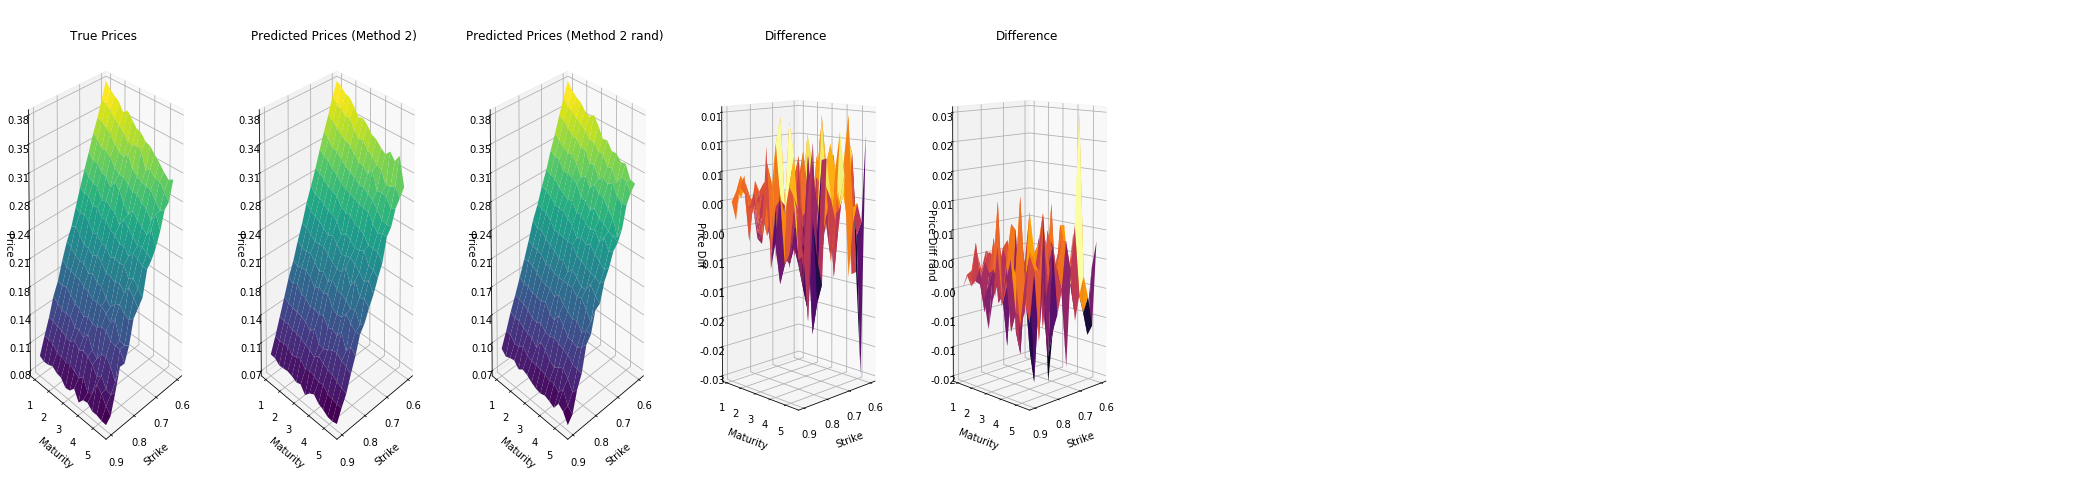

In [150]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
fig = plt.figure(figsize=(20, 9))

T_ = np.zeros((num_maturities,num_strikes))
K_ = np.zeros((num_maturities,num_strikes))
for i in range(num_strikes):
    for j in range(num_maturities):
        T_[j,i] = maturities[j]
for j in range(num_maturities):   
    for i in range(num_strikes):
        K_[j,i] = strikes[i]

ax1 = fig.add_subplot(151, projection='3d')
ax1.plot_surface(X=K_, Y=T_, Z=prices_true, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax1.set_xlabel('Strike')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('Price')
ax1.set_title('True Prices')
ax1.view_init(15, 45)

ax2 = fig.add_subplot(152, projection='3d')
ax2.plot_surface(X=K_, Y=T_, Z=prices_pred, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax2.set_xlabel('Strike')
ax2.set_ylabel('Maturity')
ax2.set_zlabel('Price')
ax2.set_title('Predicted Prices (Method 2)')
ax2.view_init(15, 45)

ax2 = fig.add_subplot(153, projection='3d')
ax2.plot_surface(X=K_, Y=T_, Z=prices_rand, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax2.set_xlabel('Strike')
ax2.set_ylabel('Maturity')
ax2.set_zlabel('Price')
ax2.set_title('Predicted Prices (Method 2 rand)')
ax2.view_init(15, 45)

ax3 = fig.add_subplot(154, projection='3d')
ax3.plot_surface(X=K_, Y=T_, Z=prices_true-prices_pred, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
ax3.zaxis.set_major_locator(LinearLocator(10))
ax3.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax3.set_xlabel('Strike')
ax3.set_ylabel('Maturity')
ax3.set_zlabel('Price Diff')
ax3.set_title('Difference')
ax3.view_init(5, 45)

ax3 = fig.add_subplot(155, projection='3d')
ax3.plot_surface(X=K_, Y=T_, Z=prices_true-prices_rand, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
ax3.zaxis.set_major_locator(LinearLocator(10))
ax3.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax3.set_xlabel('Strike')
ax3.set_ylabel('Maturity')
ax3.set_zlabel('Price Diff rand')
ax3.set_title('Difference')
ax3.view_init(5, 45)

plt.savefig('prices_cnn.pdf') 
plt.show()

In [151]:
mean_err = np.mean(np.mean(np.abs(prices_true-prices_pred),axis=0),axis=0)
mean_err_rand = np.mean(np.mean(np.abs(prices_true-prices_rand),axis=0),axis=0)
mean_true_price = np.mean(np.mean(np.abs(prices_true),axis=0),axis=0)
print("MSE: ",mean_err)
print("MSE Rand: ",mean_err_rand)
print("Percent of avg True Price: ",mean_err/mean_true_price*100)
print(init)
print(theta_true)
print(theta_pred)

MSE:  0.004321111345716132
MSE Rand:  0.004144541045309062
Percent of avg True Price:  2.0340588902741796
[0.06483100342485633, 0.3143506759599528, -0.0016709187234452694]
[0.1, 0.5, -0.5]
[ 0.05756985  0.62173915 -0.43165946]


### Create Grid of Model Parameters and corresponding Prices

In [97]:
def prices_grid(theta):
    prices_true = np.zeros((1,num_strikes*num_maturities))
    n = 100
    dim = 50
    for i in range(num_maturities):
        for j in range(num_strikes):        
            prices_true[0,i*num_strikes+j] = price_pred(theta_true[0],theta_true[1],theta_true[2],n,dim,maturities[i],strikes[j],V0,S0)
    return prices_true

In [98]:
bb = 2
num_thetas = np.power(bb,num_model_parameters)
thetas_true = np.zeros((num_thetas,num_model_parameters))

for i in range(bb):
    for j in range(bb):
        for k in range(bb):
            thetas_true[i*bb*bb+j*bb+k,0] = model_bounds[0,0]+ k *(model_bounds[0,1]-model_bounds[0,0])/(bb-1)
            thetas_true[i*bb*bb+j*bb+k,1] = model_bounds[1,0]+ j *(model_bounds[1,1]-model_bounds[1,0])/(bb-1)
            thetas_true[i*bb*bb+j*bb+k,2] = model_bounds[2,0]+ i *(model_bounds[2,1]-model_bounds[2,0])/(bb-1)

In [103]:
price_grids_true = np.zeros((num_thetas,1,num_strikes*num_maturities))
price_grids_true_ = np.zeros((num_thetas,1,num_strikes,num_maturities,1))

for i in range(num_thetas):
    price_grids_true[i,:,:] = prices_grid(thetas_true[i,:])
    for j in range(num_maturities):
        for k in range(num_strikes):
            price_grids_true_[i,0,j,k,0] = price_grids_true[i,0,j*num_strikes+i]

In [111]:
thetas_pred = np.zeros((num_thetas,num_model_parameters))
with tf.Session() as sess:                          
    saver.restore(sess, "./models/sabr_cnn")    
    theta_pred_scaled = np.zeros((1,num_model_parameters))
    for i in range(num_thetas):
        theta_pred_scaled[0,:] = sess.run(outputs,feed_dict={X: price_grids_true_[i,:,:,:,:]})[0]
 
        thetas_pred[i,:] = reverse_transform_y(theta_pred_scaled)[0,:]


INFO:tensorflow:Restoring parameters from ./models/sabr_cnn


8